In [7]:
import pandas as pd
import numpy as np
import optuna
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
SEED = 1234

# 1. Cargar y preparar los datos
datos = pd.read_csv("data\Temp_Asu20092021.csv")

# Convertir 'Fecha' a tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos desde 2019
datos = datos[datos.index.year >= 2019]

# Eliminar valores faltantes
datos.dropna(inplace=True)



MAE: 1.16


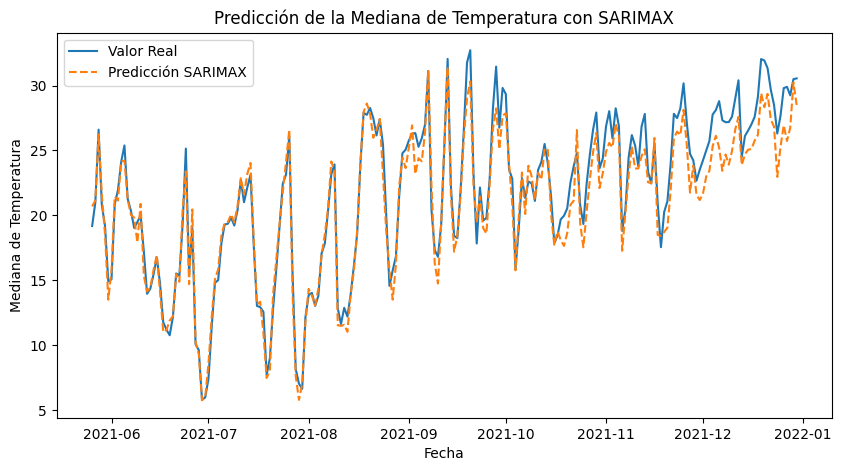

In [8]:
# Calcular percentiles diarios (95, 50, 5)

percentiles_diarios = datos.resample('D')['Temperatura'].agg(
    Percentil_95=lambda x: np.percentile(x, 95),
    Mediana=lambda x: np.percentile(x, 50),
    Percentil_5=lambda x: np.percentile(x, 5)
)



# Crear las variables objetivo para el día siguiente
percentiles_diarios['Percentil_95_siguiente'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente'] = percentiles_diarios['Percentil_5'].shift(-1)

#  Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)


y = percentiles_diarios[['Mediana_siguiente']].values
X = percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values  # Usamos el índice como variable temporal

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=False
)

# 2. Definir la función objetivo para Optuna
def objetivo(trial):
    # Hiperparámetros para SARIMAX
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)
    seasonal_order = (trial.suggest_int('P', 0, 2),
                      trial.suggest_int('D', 0, 1),
                      trial.suggest_int('Q', 0, 2),
                      trial.suggest_int('s', 7, 30))  # Cambiar 's' según la estacionalidad esperada
    
    # Ajustar el modelo SARIMAX
    modelo = sm.tsa.SARIMAX(y_train, order=(p, d, q), seasonal_order=seasonal_order)
    resultado = modelo.fit(disp=False)
    
    # Hacer predicciones
    predicciones = resultado.forecast(steps=len(y_test))
    mae = mean_absolute_error(y_test, predicciones)
    return mae

# 3. Optimización con Optuna
estudio = optuna.create_study(direction='minimize')
estudio.optimize(objetivo, n_trials=20)

# 4. Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:")
print(estudio.best_params)

# 5. Ajustar el modelo final con los mejores hiperparámetros
mejores_hyperparams = estudio.best_params
modelo_final = sm.tsa.SARIMAX(y_train, 
                               order=(mejores_hyperparams['p'], mejores_hyperparams['d'], mejores_hyperparams['q']), 
                               seasonal_order=(mejores_hyperparams['P'], mejores_hyperparams['D'], mejores_hyperparams['Q'], mejores_hyperparams['s']))
resultado_final = modelo_final.fit(disp=False)

# 6. Evaluar el modelo final
predicciones_finales = resultado_final.forecast(steps=len(y_test))
mae_final = mean_absolute_error(y_test, predicciones_finales)
print(f'MAE en validación: {mae_final:.2f}')

# 7. Graficar predicciones
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Valor Real', color='blue')
plt.plot(predicciones_finales, label='Predicción SARIMAX', color='red', linestyle='--')
plt.xlabel('Días')
plt.ylabel('Mediana de Temperatura')
plt.title('Predicción de la Mediana de Temperatura con SARIMAX Optimizado')
plt.legend()
plt.show()